In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd

from sklearn import cluster
from sklearn.preprocessing import scale

from shapely.geometry import Point
import geoplot as gplt
import geoplot.crs as gcrs
import cartopy
import cartopy.crs as ccrs

sns.set(style="whitegrid")

C:\Users\rgado\Anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
# reading shapefile (census tract boundaries)
sftracts = gpd.read_file('censusneighborhood.dbf')

# dropping unnecessary columns
sftracts.drop(columns = ["geoid", "shape_area", "shape_len"], inplace = True)

# setting census tract ID as index to make map creation easier
sftracts.set_index("tractce10", inplace = True)

sftracts.head()

,nhood,geometry
tractce10,,
016400,Hayes Valley,POLYGON ((-122.4324669997095 37.77375700028448...
016100,Western Addition,POLYGON ((-122.4235409996432 37.77967400025458...
015900,Western Addition,POLYGON ((-122.4246870001921 37.78533500040309...
015500,Japantown,POLYGON ((-122.4246870001921 37.78533500040309...
015300,Pacific Heights,POLYGON ((-122.4349179998128 37.78587599994257...


In [3]:
# Counting the number of neighborhoods in San Francisco
sftracts['nhood'].nunique()

41

In [4]:
# Loading neighborhood boundaries
sfnhoods = gpd.read_file("neighborhood.dbf")
sfnhoods.set_index('nhood', inplace = True)

sfnhoods.head()

,geometry
nhood,
Bayview Hunters Point,POLYGON ((-122.3815777424142 37.75307043091241...
Bernal Heights,"POLYGON ((-122.403612999828 37.74933700015653,..."
Castro/Upper Market,POLYGON ((-122.4265550005568 37.76948499984702...
Chinatown,POLYGON ((-122.4062259995664 37.79755900029376...
Excelsior,POLYGON ((-122.4239820002333 37.73155199975518...


In [5]:
# Reading incidents without location column
sf_inc = pd.read_csv('police-department-incidents.csv', usecols = lambda x: x not in ['Location'],
                  dtype = {'IncidntNum':str})

# Converting to datetime and merging date/time columns
sf_inc['Date'] = pd.to_datetime(sf_inc.Date)
sf_inc['Date'] = pd.to_datetime(sf_inc.Date.dt.date.astype(str)
                               + ' ' + sf_inc.Time)
sf_inc.drop('Time', axis = 1, inplace = True)

# Converting coordinates to points
sf_inc['Coordinates'] = (sf_inc[['X', 'Y']].apply(tuple, axis = 1).apply(Point))

# Convert dataframe to geodataframe
sf_inc = gpd.GeoDataFrame(sf_inc, geometry = 'Coordinates')

sf_inc.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,PdDistrict,Resolution,Address,X,Y,PdId,Coordinates
0,050436712,ASSAULT,BATTERY,Wednesday,2005-04-20 04:00:00,MISSION,NONE,18TH ST / CASTRO ST,-122.435003,37.760888,5043671204134,POINT (-122.435002864271 37.7608878061245)
1,080049078,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Sunday,2008-01-13 18:00:00,PARK,NONE,1100 Block of CLAYTON ST,-122.446838,37.762255,8004907806304,POINT (-122.446837820235 37.7622550270122)
2,130366639,ASSAULT,AGGRAVATED ASSAULT WITH A KNIFE,Sunday,2013-05-05 04:10:00,INGLESIDE,"ARREST, BOOKED",0 Block of SGTJOHNVYOUNG LN,-122.444707,37.724931,13036663904012,POINT (-122.444707063455 37.7249307267936)
3,030810835,DRIVING UNDER THE INFLUENCE,DRIVING WHILE UNDER THE INFLUENCE OF ALCOHOL,Tuesday,2003-07-08 01:00:00,SOUTHERN,"ARREST, BOOKED",MASON ST / TURK ST,-122.408954,37.783288,3081083565050,POINT (-122.408953598286 37.78328787354911)
4,130839567,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Friday,2013-10-04 20:53:00,TENDERLOIN,"ARREST, BOOKED",TURK ST / LEAVENWORTH ST,-122.414056,37.782793,13083956765010,POINT (-122.414056291891 37.7827931071006)


In [6]:
# Spatial join function of sftracts (area polygons of census tracts
# and the name of its associated neighborhood) and sf_incidents (points of police incidents
# with data that describes them)

sf_inc.crs = sftracts.crs # Making sure the map projections of both geodataframes are the same
sf_inc = gpd.sjoin(sf_inc, sftracts) # joining the geodataframes on its spatial geometries
sf_inc.rename(columns={"index_right":"tractce10"}, inplace=True)
sf_inc.iloc[:,::-1].head()

,nhood,tractce10,Coordinates,PdId,Y,X,Address,Resolution,PdDistrict,Date,DayOfWeek,Descript,Category,IncidntNum
0,Castro/Upper Market,020500,POINT (-122.435002864271 37.7608878061245),5043671204134,37.760888,-122.435003,18TH ST / CASTRO ST,NONE,MISSION,2005-04-20 04:00:00,Wednesday,BATTERY,ASSAULT,050436712
152,Castro/Upper Market,020500,POINT (-122.435002864298 37.7608878061194),7101411306111,37.760888,-122.435003,CASTRO ST / 18TH ST,NONE,MISSION,2007-09-30 23:30:00,Sunday,GRAND THEFT PICKPOCKET,LARCENY/THEFT,071014113
466,Castro/Upper Market,020500,POINT (-122.436502740795 37.75913465104571),3124164106303,37.759135,-122.436503,4200 Block of 19TH ST,NONE,MISSION,2003-10-22 09:15:00,Wednesday,PETTY THEFT FROM A BUILDING,LARCENY/THEFT,031241641
565,Castro/Upper Market,020500,POINT (-122.436102868825 37.7600036963355),6104817216710,37.760004,-122.436103,100 Block of COLLINGWOOD ST,"ARREST, BOOKED",MISSION,2006-10-01 14:22:00,Sunday,POSSESSION OF NARCOTICS PARAPHERNALIA,DRUG/NARCOTIC,061048172
689,Castro/Upper Market,020500,POINT (-122.437044118312 37.7599465464508),3039124919077,37.759947,-122.437044,100 Block of DIAMOND ST,"ARREST, BOOKED",MISSION,2003-04-03 10:26:00,Thursday,LOITERING ABOUT SCHOOL/PLAYGROUND,LOITERING,030391249


Here we have matched each police incident to a census tract and neighborhood in San Francisco. There was about 1000 police incidents that were dropped during the spatial join though these only occured when either:

- these were incidents on the edge of the city limits but just outside
- wrong/default coordinates nowhere near the city
- incident took place on a bridge between two census tracts where the bridge is not part of any census tract

Though, this is a small fraction of lost information so it should not affect our results too much. 

In [7]:
sf_inc.reset_index(drop = True)

,IncidntNum,Category,Descript,DayOfWeek,Date,PdDistrict,Resolution,Address,X,Y,PdId,Coordinates,tractce10,nhood
0,050436712,ASSAULT,BATTERY,Wednesday,2005-04-20 04:00:00,MISSION,NONE,18TH ST / CASTRO ST,-122.435003,37.760888,5043671204134,POINT (-122.435002864271 37.7608878061245),020500,Castro/Upper Market
1,071014113,LARCENY/THEFT,GRAND THEFT PICKPOCKET,Sunday,2007-09-30 23:30:00,MISSION,NONE,CASTRO ST / 18TH ST,-122.435003,37.760888,7101411306111,POINT (-122.435002864298 37.7608878061194),020500,Castro/Upper Market
2,031241641,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Wednesday,2003-10-22 09:15:00,MISSION,NONE,4200 Block of 19TH ST,-122.436503,37.759135,3124164106303,POINT (-122.436502740795 37.75913465104571),020500,Castro/Upper Market
3,061048172,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Sunday,2006-10-01 14:22:00,MISSION,"ARREST, BOOKED",100 Block of COLLINGWOOD ST,-122.436103,37.760004,6104817216710,POINT (-122.436102868825 37.7600036963355),020500,Castro/Upper Market
4,030391249,LOITERING,LOITERING ABOUT SCHOOL/PLAYGROUND,Thursday,2003-04-03 10:26:00,MISSION,"ARREST, BOOKED",100 Block of DIAMOND ST,-122.437044,37.759947,3039124919077,POINT (-122.437044118312 37.7599465464508),020500,Castro/Upper Market
5,090197037,BURGLARY,"BURGLARY,STORE UNDER CONSTRUCTION, FORCIBLE ENTRY",Monday,2009-02-23 15:41:00,MISSION,"ARREST, BOOKED",500 Block of CASTRO ST,-122.434995,37.760070,9019703705151,POINT (-122.434994783089 37.76006971065671),020500,Castro/Upper Market
6,080619609,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Thursday,2008-06-05 20:30:00,MISSION,NONE,4100 Block of 18TH ST,-122.435573,37.760911,8061960964070,POINT (-122.435573154199 37.7609106220681),020500,Castro/Upper Market
7,071024805,VANDALISM,MALICIOUS MISCHIEF,Friday,2007-10-05 18:45:00,MISSION,NONE,100 Block of EUREKA ST,-122.438256,37.759873,7102480528090,POINT (-122.438256384623 37.7598729839802),020500,Castro/Upper Market
8,100775979,LARCENY/THEFT,PETTY THEFT SHOPLIFTING,Monday,2010-08-23 19:08:00,MISSION,NONE,500 Block of CASTRO ST,-122.434995,37.760070,10077597906361,POINT (-122.434994783089 37.76006971065671),020500,Castro/Upper Market
9,130494042,WEAPON LAWS,"WEAPON, ASSAULT, POSSESSION, MANUFACTURE, OR SALE",Sunday,2013-06-16 03:00:00,MISSION,"ARREST, BOOKED",CASTRO ST / 18TH ST,-122.435003,37.760888,13049404212171,POINT (-122.435002864298 37.7608878061194),020500,Castro/Upper Market


In [8]:
# subsample of dating in year of 2015-2017, chosen because it is
# the most recent range of years to see the change in crime rate/type/location

sf_inc_sub15 = sf_inc.loc[sf_inc.Date.dt.year == 2015]
sf_inc_sub16 = sf_inc.loc[sf_inc.Date.dt.year == 2016]
sf_inc_sub17 = sf_inc.loc[sf_inc.Date.dt.year == 2017]

range_15to17 = [sf_inc_sub15, sf_inc_sub16, sf_inc_sub17]
years = [2015, 2016, 2017]

In [9]:
# Number of overall crime in 2015, 2016, and 2017, respectively

i = -1
for df in range_15to17:
    i += 1
    print('Crimes in ' + str(years[i]) + ': ' + str(df.shape[0]))           

Crimes in 2015: 156450
Crimes in 2016: 150846
Crimes in 2017: 154739


In [10]:
# Showcasing neighborhood with most police incidents from 2015-2017
i = -1
for df in range_15to17:
    i += 1
    print(str(years[i]))
    print((df.nhood.value_counts().to_frame().rename(columns = {'nhood': 'Incidents'}).head()))
    print('')

2015
                                Incidents
South of Market                     18182
Mission                             16492
Tenderloin                          15666
Financial District/South Beach      12780
Bayview Hunters Point                9507

2016
                                Incidents
South of Market                     17755
Mission                             17112
Tenderloin                          14808
Financial District/South Beach      11715
Bayview Hunters Point                8872

2017
                                Incidents
Mission                             18426
South of Market                     18157
Tenderloin                          14157
Financial District/South Beach      11342
Bayview Hunters Point                8425



Note there was a reduction in highest crimes in 2016, though that number gets higher in 2017 and South of Market takes the highest mark.

In [11]:
# Showcasing census tract with most police incidents from 2015-2017

i = -1
for df in range_15to17:
    i += 1
    print(str(years[i]))
    print('')
    print((df.tractce10.value_counts().to_frame().rename(columns = {'tractce10': 'Incidents'}).head()))
    print('')

2015

        Incidents
017601       7395
018000       6317
061500       5634
011700       5218
012402       3948

2016

        Incidents
017601       7882
018000       5756
061500       5159
011700       4877
012402       3997

2017

        Incidents
017601       7577
018000       6955
011700       4877
061500       4696
012402       4093



Note here that, contrary to the previous incidents by neighborhoods, the census tract peaks at 2016 then goes down in 2017. This time, however, the top census tract is the same and instead the change is between 011700 and 061500 in 2017.

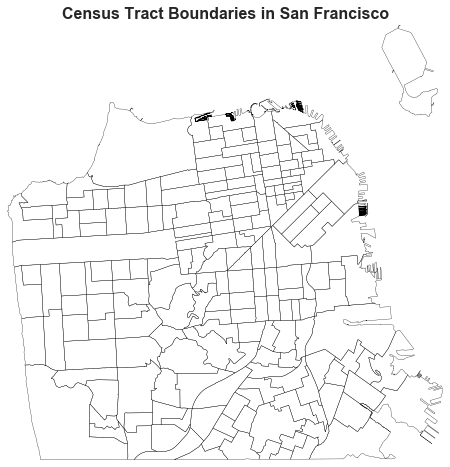

In [12]:
# Printing the general census tract boundary

ax = gplt.polyplot(sftracts.geometry, projection = gcrs.LambertConformal(),
                   figsize=(12,8), edgecolor="k")
ax.set_title("Census Tract Boundaries in San Francisco", fontweight="bold", fontsize=16)
plt.show()

In [13]:
vehicletheft_inc_by_tract_15 = gpd.GeoDataFrame((sf_inc_sub15
                                     .loc[sf_inc_sub15["Category"] == "VEHICLE THEFT"]
                                     .tractce10.value_counts()
                                     .to_frame()
                                     .rename(columns={"tractce10":"Incidents"})
                                    ).merge(sftracts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )

vehicletheft_inc_by_tract_16 = gpd.GeoDataFrame((sf_inc_sub16
                                     .loc[sf_inc_sub16["Category"] == "VEHICLE THEFT"]
                                     .tractce10.value_counts()
                                     .to_frame()
                                     .rename(columns={"tractce10":"Incidents"})
                                    ).merge(sftracts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )

vehicletheft_inc_by_tract_17 = gpd.GeoDataFrame((sf_inc_sub17
                                     .loc[sf_inc_sub17["Category"] == "VEHICLE THEFT"]
                                     .tractce10.value_counts()
                                     .to_frame()
                                     .rename(columns={"tractce10":"Incidents"})
                                    ).merge(sftracts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )

# For example, will show vehicletheft indicents in 2015
vehicletheft_inc_by_tract_15.head()

,Incidents,geometry
061500,176,(POLYGON ((-122.3938190003501 37.7937379999223...
017601,158,POLYGON ((-122.4027080002739 37.78325899990071...
017700,154,POLYGON ((-122.4155609997469 37.77310099980595...
980900,136,"POLYGON ((-122.3741180225235 37.7449732075358,..."
025500,130,POLYGON ((-122.4280380002034 37.73201600020357...


In [14]:
burglary_inc_by_tract_15 = gpd.GeoDataFrame((sf_inc_sub15
                                     .loc[sf_inc_sub15["Category"] == "BURGLARY"]
                                     .tractce10.value_counts()
                                     .to_frame()
                                     .rename(columns={"tractce10":"Incidents"})
                                    ).merge(sftracts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )
burglary_inc_by_tract_16 = gpd.GeoDataFrame((sf_inc_sub16
                                     .loc[sf_inc_sub16["Category"] == "BURGLARY"]
                                     .tractce10.value_counts()
                                     .to_frame()
                                     .rename(columns={"tractce10":"Incidents"})
                                    ).merge(sftracts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )

burglary_inc_by_tract_17 = gpd.GeoDataFrame((sf_inc_sub17
                                     .loc[sf_inc_sub17["Category"] == "BURGLARY"]
                                     .tractce10.value_counts()
                                     .to_frame()
                                     .rename(columns={"tractce10":"Incidents"})
                                    ).merge(sftracts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )

# For example will show drug tract in 2015
burglary_inc_by_tract_15.head()

,Incidents,geometry
061500,207,(POLYGON ((-122.3938190003501 37.7937379999223...
011700,191,POLYGON ((-122.3963019999436 37.79325600032029...
017601,183,POLYGON ((-122.4027080002739 37.78325899990071...
018000,139,"POLYGON ((-122.392749999479 37.77885199978907,..."
017700,119,POLYGON ((-122.4155609997469 37.77310099980595...


In [15]:
vandalism_inc_by_tract_15 = gpd.GeoDataFrame((sf_inc_sub15
                                     .loc[sf_inc_sub15["Category"] == "VANDALISM"]
                                     .tractce10.value_counts()
                                     .to_frame()
                                     .rename(columns={"tractce10":"Incidents"})
                                    ).merge(sftracts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )

vandalism_inc_by_tract_16 = gpd.GeoDataFrame((sf_inc_sub16
                                     .loc[sf_inc_sub16["Category"] == "VANDALISM"]
                                     .tractce10.value_counts()
                                     .to_frame()
                                     .rename(columns={"tractce10":"Incidents"})
                                    ).merge(sftracts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )

vandalism_inc_by_tract_17 = gpd.GeoDataFrame((sf_inc_sub17
                                     .loc[sf_inc_sub17["Category"] == "VANDALISM"]
                                     .tractce10.value_counts()
                                     .to_frame()
                                     .rename(columns={"tractce10":"Incidents"})
                                    ).merge(sftracts.geometry.to_frame(),
                                            left_index=True, right_index=True)
                                   )

# For example, will show arson indicents in 2015
vandalism_inc_by_tract_15.head()

,Incidents,geometry
018000,317,"POLYGON ((-122.392749999479 37.77885199978907,..."
061500,272,(POLYGON ((-122.3938190003501 37.7937379999223...
017601,263,POLYGON ((-122.4027080002739 37.78325899990071...
010100,215,(POLYGON ((-122.4199157334139 37.8115742942702...
017802,196,POLYGON ((-122.4018429996724 37.77903200015587...


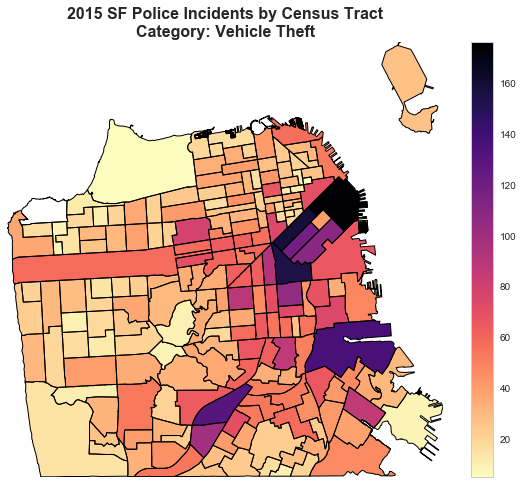

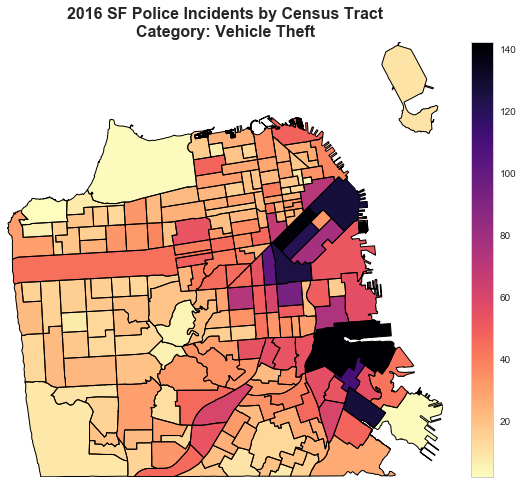

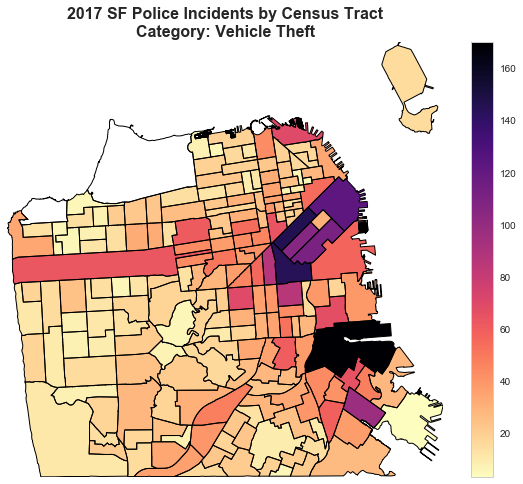

In [17]:
ax1 = gplt.choropleth(vehicletheft_inc_by_tract_15, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="magma_r", k=None, linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sftracts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax1)
ax1.set_title("2015 SF Police Incidents by Census Tract\nCategory: Vehicle Theft",
             fontweight="bold", fontsize=16)

ax2 = gplt.choropleth(vehicletheft_inc_by_tract_16, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="magma_r", k=None, linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sftracts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax2)
ax2.set_title("2016 SF Police Incidents by Census Tract\nCategory: Vehicle Theft",
             fontweight="bold", fontsize=16)

ax3 = gplt.choropleth(vehicletheft_inc_by_tract_17, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="magma_r", k=None, linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sftracts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax3)
ax3.set_title("2017 SF Police Incidents by Census Tract\nCategory: Vehicle Theft",
             fontweight="bold", fontsize=16)

plt.show()

Based on our research, we will look at factors at crimes that are classified as property crime (burglary, vehicle theft, vandalism, etc.) to see the relation.

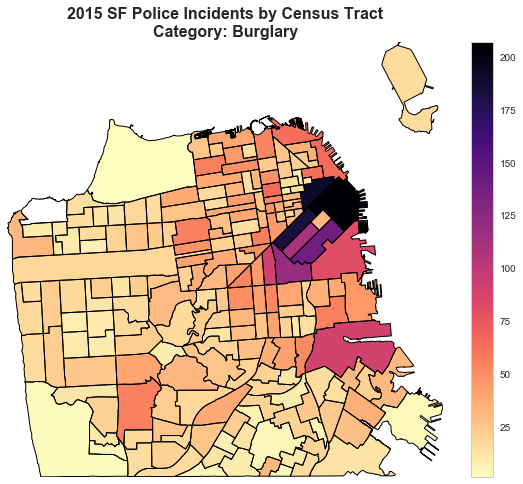

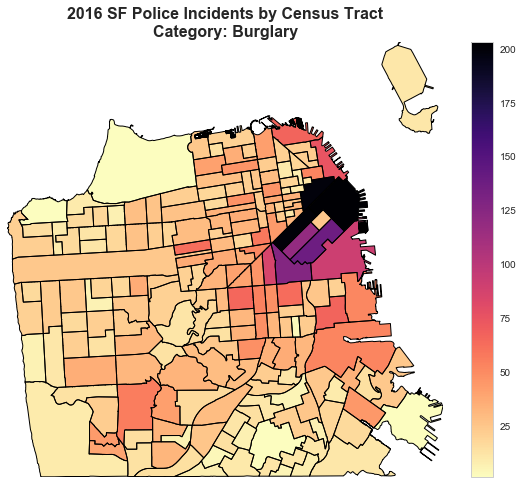

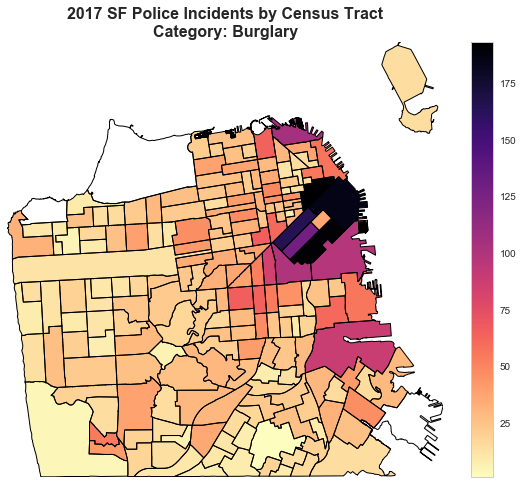

In [18]:
ax1 = gplt.choropleth(burglary_inc_by_tract_15, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="magma_r", k=None, linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sftracts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax1)
ax1.set_title("2015 SF Police Incidents by Census Tract\nCategory: Burglary",
             fontweight="bold", fontsize=16)

ax2 = gplt.choropleth(burglary_inc_by_tract_16, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="magma_r", k=None, linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sftracts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax2)
ax2.set_title("2016 SF Police Incidents by Census Tract\nCategory: Burglary",
             fontweight="bold", fontsize=16)

ax3 = gplt.choropleth(burglary_inc_by_tract_17, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="magma_r", k=None, linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sftracts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax3)
ax3.set_title("2017 SF Police Incidents by Census Tract\nCategory: Burglary",
             fontweight="bold", fontsize=16)

plt.show()

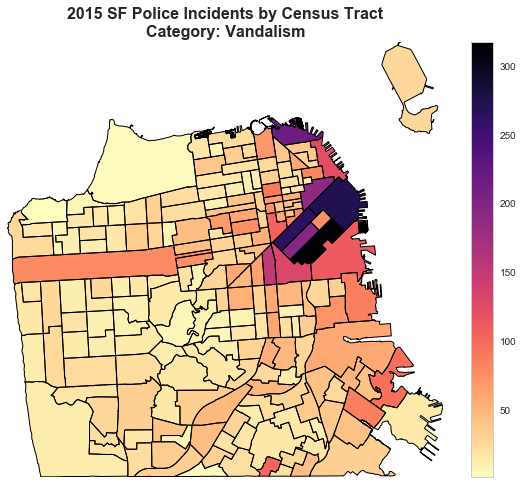

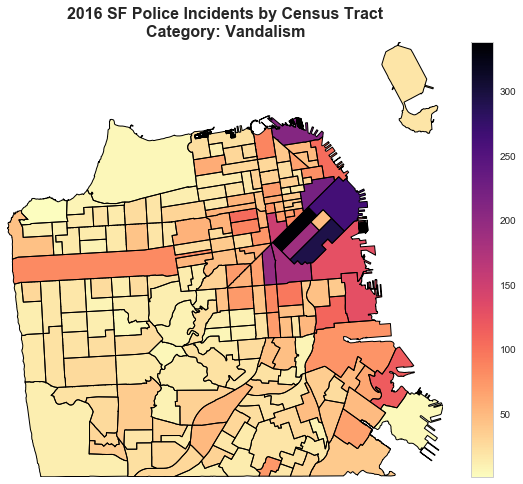

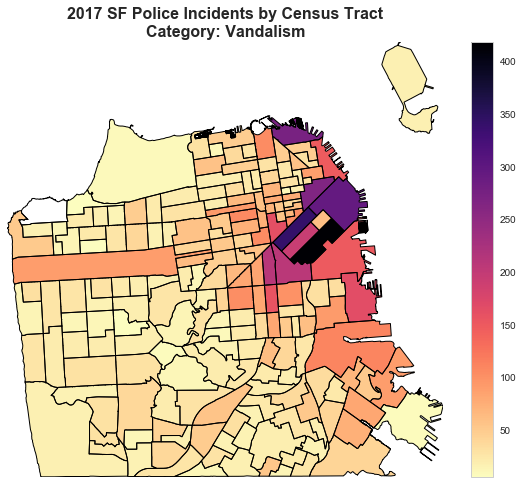

In [20]:
ax1 = gplt.choropleth(vandalism_inc_by_tract_15, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="magma_r", k=None, linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sftracts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax1)
ax1.set_title("2015 SF Police Incidents by Census Tract\nCategory: Vandalism",
             fontweight="bold", fontsize=16)

ax2 = gplt.choropleth(vandalism_inc_by_tract_16, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="magma_r", k=None, linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sftracts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax2)
ax2.set_title("2016 SF Police Incidents by Census Tract\nCategory: Vandalism",
             fontweight="bold", fontsize=16)

ax3 = gplt.choropleth(vandalism_inc_by_tract_17, projection=gcrs.LambertConformal(), hue="Incidents",
                     cmap="magma_r", k=None, linewidth=0, figsize=(10,8), legend=True)
gplt.polyplot(sftracts.geometry, projection = gcrs.LambertConformal(), edgecolor="k",
              linewidth=1, ax=ax3)
ax3.set_title("2017 SF Police Incidents by Census Tract\nCategory: Vandalism",
             fontweight="bold", fontsize=16)

plt.show()

In [ ]:
ax1 = gplt.aggplot(sf_inc_sub15,
                  projection=gcrs.LambertConformal(),
                  hue="PdId", agg=lambda x: np.log10(len(x)), by="nhood",
                  geometry=sfnhoods.geometry, cmap="viridis", linewidth=0, figsize=(12,8),
                  vmin=2, vmax=4)
gplt.polyplot(sftracts.geometry, gcrs.LambertConformal(), ax=ax1, linewidth=0.5, edgecolor="w")
gplt.polyplot(sfnhoods.geometry, gcrs.LambertConformal(), ax=ax1, edgecolor="k")
ax1.set_title("2015 SF Police Incidents (Total) by Neighborhood\n Log-Transformed",
             fontweight="bold", fontsize=16)

ax2 = gplt.aggplot(sf_inc_sub16,
                  projection=gcrs.LambertConformal(),
                  hue="PdId", agg=lambda x: np.log10(len(x)), by="nhood",
                  geometry=sfnhoods.geometry, cmap="viridis", linewidth=0, figsize=(12,8),
                  vmin=2, vmax=4)
gplt.polyplot(sftracts.geometry, gcrs.LambertConformal(), ax=ax2, linewidth=0.5, edgecolor="w")
gplt.polyplot(sfnhoods.geometry, gcrs.LambertConformal(), ax=ax2, edgecolor="k")
ax2.set_title("2016 SF Police Incidents (Total) by Neighborhood\n Log-Transformed",
             fontweight="bold", fontsize=16)

ax3 = gplt.aggplot(sf_inc_sub17,
                  projection=gcrs.LambertConformal(),
                  hue="PdId", agg=lambda x: np.log10(len(x)), by="nhood",
                  geometry=sfnhoods.geometry, cmap="viridis", linewidth=0, figsize=(12,8),
                  vmin=2, vmax=4)
gplt.polyplot(sftracts.geometry, gcrs.LambertConformal(), ax=ax3, linewidth=0.5, edgecolor="w")
gplt.polyplot(sfnhoods.geometry, gcrs.LambertConformal(), ax=ax3, edgecolor="k")
ax3.set_title("2017 SF Police Incidents (Total) by Neighborhood\n Log-Transformed",
             fontweight="bold", fontsize=16)
plt.show()

In [17]:
# Takes a grouped dataframe and calculates the percentage change in incidents
# from a base year to another year

def crime_change(g, t0=2014, t1=2015): # calculates percentage changes
    g = g.dt.year
    a = len(g.loc[g==t1])
    b = len(g.loc[g==t0])
    if b > 0:
        c = 100*(a-b)/b
    elif ((b == 0) & (a > 0)):
        c = np.nan
    else: 
        c = 0
    return c

# Creates a dataframe by using the aggregation method from the first function

def crime_change_data(data, t0=2014, t1=2015, category=None, geography="nhood"):
    shapes = {"nhood": sfnhoods, "tractce10": sftracts}
    if category is None:
        g = data.groupby(geography).Date
    else:
        g = data.loc[data["Category"]==category].groupby(geography).Date
    return (gpd.GeoDataFrame(g.apply(crime_change, t0=t0, t1=t1)
                           .to_frame().rename(columns={"Date":str(t0)+str(t1)+"change"})
                           )
            .join(shapes[geography], how="right")
           )

In [18]:
# Look at 2015 - 2016 and 2016 - 2017, not including Presidio because it is an outlier as a result of
# being governed by the National Park Service

crime_change1516 = (crime_change_data(sf_inc.loc[sf_inc['nhood'] != 'Presidio'],
                                    t0 = 2015, t1 = 2016, geography = 'tractce10',
                                    category = None).dropna())

crime_change1617 = (crime_change_data(sf_inc.loc[sf_inc['nhood'] != 'Presidio'],
                                    t0 = 2016, t1 = 2017, geography = 'tractce10',
                                    category = None).dropna())

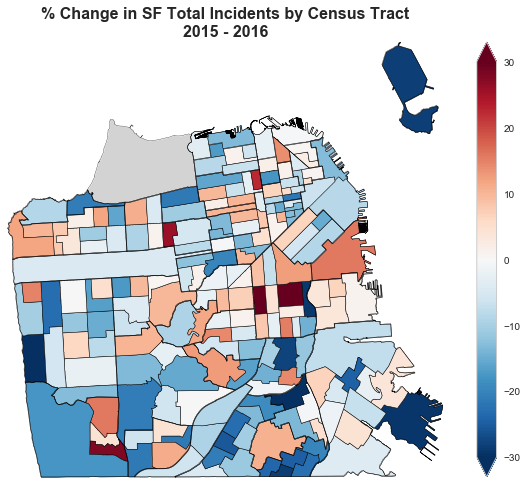

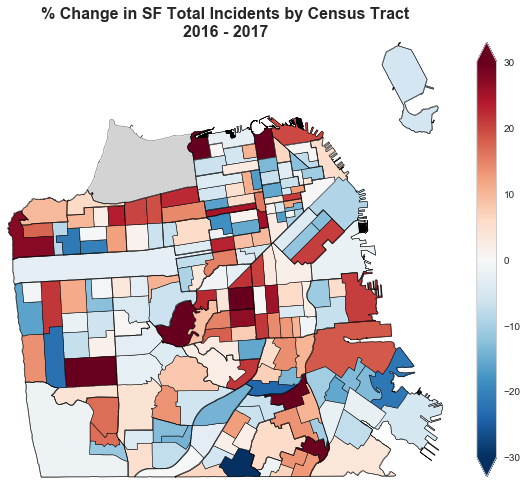

In [19]:
ax1 = gplt.polyplot(sftracts.geometry, gcrs.LambertConformal(), facecolor="lightgrey",
                   figsize=(12,8), linewidth=0)
gplt.choropleth(crime_change1516, gcrs.LambertConformal(), hue="20152016change",
                ax=ax1, k=None, cmap="RdBu_r", edgecolor="k", linewidth=0.5,
                vmin=-30, vmax=30, legend=True, legend_kwargs={"extend":"both"})
gplt.polyplot(sfnhoods.geometry, gcrs.LambertConformal(), ax=ax1, edgecolor="k")
ax1.set_title("% Change in SF Total Incidents by Census Tract\n2015 - 2016",
             fontweight="bold", fontsize=16)

ax2 = gplt.polyplot(sftracts.geometry, gcrs.LambertConformal(), facecolor="lightgrey",
                   figsize=(12,8), linewidth=0)
gplt.choropleth(crime_change1617, gcrs.LambertConformal(), hue="20162017change",
                ax=ax2, k=None, cmap="RdBu_r", edgecolor="k", linewidth=0.5,
                vmin=-30, vmax=30, legend=True, legend_kwargs={"extend":"both"})
gplt.polyplot(sfnhoods.geometry, gcrs.LambertConformal(), ax=ax2, edgecolor="k")
ax2.set_title("% Change in SF Total Incidents by Census Tract\n2016 - 2017",
             fontweight="bold", fontsize=16)

plt.show()